In [2]:
# !pip install einops torch maze-dataset --q

In [ ]:
import os
import re
import numpy as np
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm import tqdm
from torch.nn import functional as F

now = datetime.now()
formatted_time = now.strftime("%Y%m%d_%H%M%S")
loss_curves_folder = f"../data/loss_curves_{formatted_time}/stable_diffusion_diffusion_models"
if not os.path.exists(loss_curves_folder):
    os.makedirs(loss_curves_folder)

In [2]:
os.chdir("..")
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/I749793/Desktop/NUS/CS5340 - Uncertainty Modeling in AI/project/diffusion-based-environment-generator


## Loading the Dataset

In [ ]:
from generator.maze.grid_world_generator import generate_multiple_grid_worlds
from generator.maze.solvers.a_star_l1 import main as a_star_l1_paths
from generator.maze.solvers.bfs import main as bfs_paths

# parent_directory = "./data"
# if not os.path.exists(parent_directory):
#     os.makedirs(parent_directory)
# # generates the mazes
# mazes = generate_multiple_grid_worlds(num_worlds=25000, parent_directory=parent_directory)
# # generate path travrsals
# a_star_l1_paths(parent_directory)
# bfs_paths(parent_directory)

Generating Grid Worlds:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing Mazes: 100%|██████████| 1000/1000 [00:00<00:00, 1907.58maze/s]


In [4]:
# import os
# import numpy as np
# import torch
# from torch.utils.data import Dataset
# import matplotlib.pyplot as plt

# def preprocess_image(image, target_size=32):
#     image = np.array(image)

#     scale_factor = target_size // image.shape[0]
#     image = np.kron(image, np.ones((scale_factor, scale_factor, 1)))

#     image = image.astype(np.float32) / 127.5 - 1
#     image = torch.tensor(image).permute(2, 0, 1)
#     return image

# def load_dataset_from_npy(directory="./data", target_size=32):
#     images = []
#     path_lengths = []

#     files = sorted([f for f in os.listdir(directory) if f.endswith(".npy")])

#     for file in files:
#         img = np.load(os.path.join(directory, file))

#         mask = np.all(img == [0, 0, 255], axis=-1)
#         img[mask] = [255, 255, 255]
#         img = img[:-1, :-1]

#         image = preprocess_image(img, target_size)

#         base_name = os.path.splitext(file)[0]
#         len_filename = base_name + "_len.txt"
#         len_path = os.path.join(directory, len_filename)

#         with open(len_path, "r") as f:
#             maze_length = int(f.read().strip())

#         images.append(image)
#         path_lengths.append(maze_length)

#     return images, path_lengths

# images, path_lengths = load_dataset_from_npy("./data", target_size=32)

# plt.imshow(images[0].permute(1, 2, 0).cpu().numpy(), cmap='gray')
# plt.axis('off')
# plt.show()

In [5]:
def preprocess_image(image, target_size=32):
    image = np.array(image)
    scale_factor = target_size // image.shape[0] 
    # image = np.kron(image, np.ones((scale_factor, scale_factor, 1))) 
    
    # image = image.astype(np.float32) / 127.5 - 1
    image = image.astype(np.float32)
    image = torch.tensor(image).permute(2, 0, 1)
    image = F.interpolate(image.unsqueeze(0), size=(target_size, target_size), mode='nearest').squeeze(0)  # (3, 32, 32)

    return image

def plot_grid_world(grid):
    """
    Plots the given grid world.
    """
    wall = grid[:,:,0] == 0
    source = grid[:,:,1] == 1
    destination = grid[:,:,2] == 1

    img = np.ones((*wall.shape, 3), dtype=np.float32)  # White background
    img[wall] = np.array([0, 0, 0])  # Walls → Black
    img[source] = np.array([1, 0, 0])  # Source → Red
    img[destination] = np.array([0, 1, 0])  # Destination → Green

    return img

def load_dataset_from_npy(parent_directory="./data", target_size=32):
    images = []
    path_lengths = []
    num_nodes_traversed_astar = []
    num_nodes_traversed_bfs = []
    
    mazes_directory = os.path.join(parent_directory, "mazes")
    files = sorted([f for f in os.listdir(mazes_directory) if f.endswith(".npy")])
    
    for file in files:
        img = np.load(os.path.join(mazes_directory, file))
        if(img.shape != (10,10,3)):
            continue
        # mask = np.all(img == [0, 0, 255], axis=-1)
        # img[mask] = [255, 255, 255]
        # img = img[:-1, :-1]
        # image = preprocess_image(img, target_size)

        image = plot_grid_world(img)
        mask = np.all(image == [0, 0, 255], axis=-1)
        image[mask] = [255, 255, 255]
        image = preprocess_image(image, target_size)

        pattern = r'maze_(\d+)'
        match = re.search(pattern, file)
        num = 0
        if match:
            num = int(match.group(1))
        else:
            continue
        
        # base_name = os.path.splitext(file)[0]
        # len_filename = base_name + "_len.txt"
        len_filename = f"path_length_{num}" + ".npy"
        len_path = os.path.join(mazes_directory, len_filename)
        astar_traversal_filename = f"a_star_{num}" + ".npy"
        astar_traversal_path = os.path.join(parent_directory, "a_star_l1_results" ,astar_traversal_filename)
        bfs_traversal_filename = f"bfs_{num}" + ".npy"
        bfs_traversal_path = os.path.join(parent_directory, "bfs_results" ,bfs_traversal_filename)
        
        # with open(len_path, "r") as f:
        #     maze_length = int(f.read().strip())
        maze_length = np.load(len_path)
        astar_traversal = np.load(astar_traversal_path)
        bfs_traversal = np.load(bfs_traversal_path)
        
        images.append(image)
        path_lengths.append(int(maze_length))
        num_nodes_traversed_astar.append(int(astar_traversal))
        num_nodes_traversed_bfs.append(int(bfs_traversal))
    
    return images, path_lengths, num_nodes_traversed_astar, num_nodes_traversed_bfs

In [6]:
mazes_data_path = "./data/"
images, org_path_lengths, num_nodes_astar, num_nodes_bfs = load_dataset_from_npy(mazes_data_path, target_size=32)

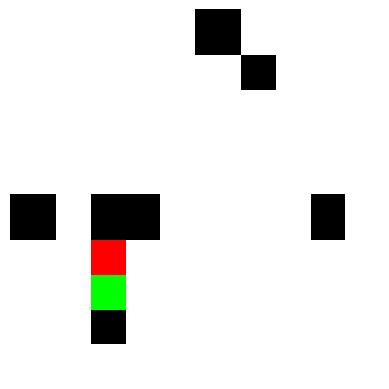

In [7]:
plt.imshow(images[0].permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

In [8]:
# print(f"Current working directory: {os.getcwd()}")
os.chdir("./diffuser")
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/I749793/Desktop/NUS/CS5340 - Uncertainty Modeling in AI/project/diffusion-based-environment-generator/diffuser


### VAE Training

In [9]:
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [ ]:
# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 300
LATENT_CHANNELS = 4

In [11]:
class MazeTensorDataset(Dataset):
    def __init__(self, images, path_lengths, num_nodes_astar, num_nodes_bfs):
        self.images = images
        self.path_lengths = path_lengths
        self.num_nodes_astar = num_nodes_astar
        self.num_nodes_bfs = num_nodes_bfs
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx], self.path_lengths[idx], self.num_nodes_astar[idx], self.num_nodes_bfs[idx]

In [12]:
# print("Total images:", len(images))
# print("Total path_lengths:", len(path_lengths))

# total = len(images)
# test_size = int(0.2 * total)
# all_indices = list(range(total))
# random.shuffle(all_indices)

# test_indices = all_indices[:test_size]
# train_indices = all_indices[test_size:]

# train_images = [images[i] for i in train_indices]
# train_path_lengths = [path_lengths[i] for i in train_indices]

# test_images = [images[i] for i in test_indices]
# test_path_lengths = [path_lengths[i] for i in test_indices]

# dataset = MazeTensorDataset(train_images, train_path_lengths)
# test_dataset = MazeTensorDataset(test_images, test_path_lengths)

# print("Train dataset length:", len(dataset))
# print("Test dataset length:", len(test_dataset))

# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# unique_train_paths = set(train_path_lengths)
# print("Unique training path lengths:", unique_train_paths)
# print("Number of unique training paths:", len(unique_train_paths))

# unique_test_paths = set(test_path_lengths)
# print("Unique test path lengths:", unique_test_paths)
# print("Number of unique test paths:", len(unique_test_paths))

In [13]:
path_lengths = org_path_lengths

## use the scaled path lengths based on the number of nodes traversed
# path_lengths = [a / b if b!=0 else a for a, b in zip(path_lengths, num_nodes_astar)]
# path_lengths = [a / b if b!=0 else a for a, b in zip(path_lengths, num_nodes_bfs)]

print("Total images:", len(images))
print("Total path_lengths:", len(path_lengths))

total = len(images)
test_size = int(0.2 * total)
all_indices = list(range(total))
random.shuffle(all_indices)

test_indices = all_indices[:test_size]
train_indices = all_indices[test_size:]

train_images = [images[i] for i in train_indices]
train_path_lengths = [path_lengths[i] for i in train_indices]
train_num_nodes_astar = [num_nodes_astar[i] for i in train_indices]
train_num_nodes_bfs = [num_nodes_bfs[i] for i in train_indices]

test_images = [images[i] for i in test_indices]
test_path_lengths = [path_lengths[i] for i in test_indices]
test_num_nodes_astar = [num_nodes_astar[i] for i in test_indices]
test_num_nodes_bfs = [num_nodes_bfs[i] for i in test_indices]

dataset = MazeTensorDataset(train_images, train_path_lengths, train_num_nodes_astar, train_num_nodes_bfs)
test_dataset = MazeTensorDataset(test_images, test_path_lengths, test_num_nodes_astar, test_num_nodes_bfs)

print("Train dataset length:", len(dataset))
print("Test dataset length:", len(test_dataset))

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

unique_train_paths = set(train_path_lengths)
print("Unique training path lengths:", unique_train_paths)
print("Number of unique training paths:", len(unique_train_paths))

unique_test_paths = set(test_path_lengths)
print("Unique test path lengths:", unique_test_paths)
print("Number of unique test paths:", len(unique_test_paths))

Total images: 1000
Total path_lengths: 1000
Train dataset length: 800
Test dataset length: 200
Unique training path lengths: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22}
Number of unique training paths: 21
Unique test path lengths: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20}
Number of unique test paths: 19


In [17]:
# import safetensors
# print(safetensors.__file__)

# from safetensors.torch import save_file, load_file
# print("Success!")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from diffusers import UNet2DConditionModel, DDIMScheduler, AutoencoderKL
from model import Diffusion as CustomDiffusionModel

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Stable Diffusion's pre-trained VAE
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae").to(device)
vae_checkpoint = torch.load("../data/vae_models/stablediffusion_vae_weights.pth", map_location=device)  # or "cuda" if you want
vae_state_dict = vae_checkpoint['diffusion_state_dict']
vae.load_state_dict(vae_state_dict)
# optimizer = optim.Adam(vae.parameters(), lr=1e-4)
# criterion = nn.MSELoss()
# loading pretrained vae instead

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Using device: cpu


In [ ]:
train_losses = []
# ---- Training Loop ---- #
def train_vae(dataloader, epochs=50):
    vae.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for i, (images, _, _, _) in enumerate(dataloader):
            images = images.to(device)  # Input maze images (shape: B x 3 x 256 x 256)

            # Forward pass
            latent_dist = vae.encode(images).latent_dist
            latent_sample = latent_dist.sample()
            reconstructed_images = vae.decode(latent_sample).sample

            # Loss computation
            loss = criterion(reconstructed_images, images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.6f}")

# train_vae(dataloader, epochs=2)


Epoch [1/2], Loss: 0.103098
Epoch [2/2], Loss: 0.079886


In [ ]:
# torch.save({
#     'diffusion_state_dict': vae.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'train_losses': train_losses
# }, 'diffusion_weights.pth')
# print("Diffusion weights saved to diffusion_weights.pth")

In [ ]:
# # Save Model Weights
# if not os.path.exists(f"../data/loss_curves_{formatted_time}/stable_diffusion_vae_models/"):
#     os.makedirs(f"../data/loss_curves_{formatted_time}/stable_diffusion_vae_models/")
# torch.save({
#     'vae_state_dict': vae.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'train_losses': train_losses,
# }, f'../data/loss_curves_{formatted_time}/stable_diffusion_vae_models/vae_weights_multi_feat.pth')

# print("Model weights saved to vae_weights_multi_feat.pth")

Model weights saved to vae_weights_multi_feat.pth


### VAE Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.41595674..1.1078708].


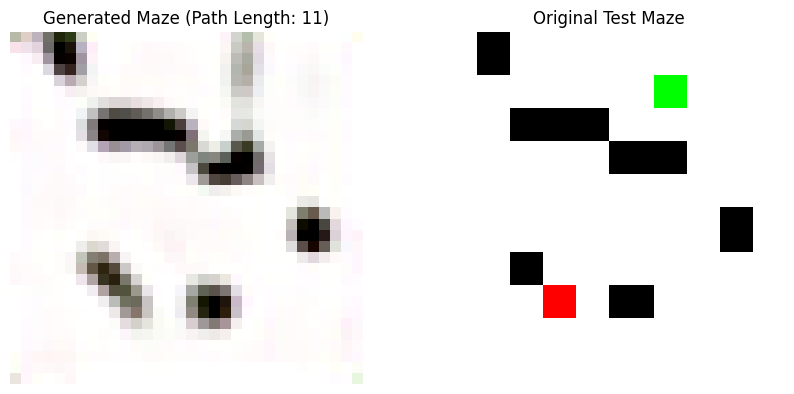

In [ ]:
# vae.eval()
# def generate_maze_from_test(sample_idx=None):

#     if sample_idx is None:
#         sample_idx = random.randint(0, len(test_dataset) - 1)

#     test_img, test_path_length, _, _ = test_dataset[sample_idx]  # Load test maze
#     test_img = test_img.unsqueeze(0).to(device)  # Add batch dimension

#     # Encode test maze image into latent space
#     with torch.no_grad():
#         latent_dist = vae.encode(test_img).latent_dist
#         latent_sample = latent_dist.sample()  # Sample from the distribution

#         # Decode latent back to an image
#         generated_image = vae.decode(latent_sample).sample

#     return generated_image, test_img, test_path_length

# # Run test generation
# generated, original, test_path_length = generate_maze_from_test()

# # ---- Visualization ---- #
# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.imshow(generated.squeeze(0).permute(1, 2, 0).cpu().numpy(), cmap='gray')
# plt.title(f"Generated Maze (Path Length: {test_path_length})")
# plt.axis("off")

# plt.subplot(1, 2, 2)
# plt.imshow(original.squeeze(0).permute(1, 2, 0).cpu().numpy(), cmap='gray')
# plt.title("Original Test Maze")
# plt.axis("off")
# plt.show()

# Diffusion

In [ ]:
# Hyperparams
NUM_TIMESTEPS = 1000
GUIDANCE_SCALE = 7.5
LATENT_SHAPE = (4, 64, 64)  # For SD 1.5
EPOCHS = 75

In [23]:
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet").to(device)
unet.train()
scheduler = DDIMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")
custom_diffusion_model = CustomDiffusionModel(input_size=2).to(device)
scheduler.set_timesteps(NUM_TIMESTEPS)
vae.eval()
optimizer = torch.optim.Adam(list(unet.parameters()), lr=1e-5)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

### Stable Diffusion Training

Training epoch [1/2]: 100%|██████████| 7/7 [05:19<00:00, 45.60s/it]


[Epoch 1] Loss: 0.762381


Training epoch [2/2]: 100%|██████████| 7/7 [05:15<00:00, 45.12s/it]

[Epoch 2] Loss: 0.522686


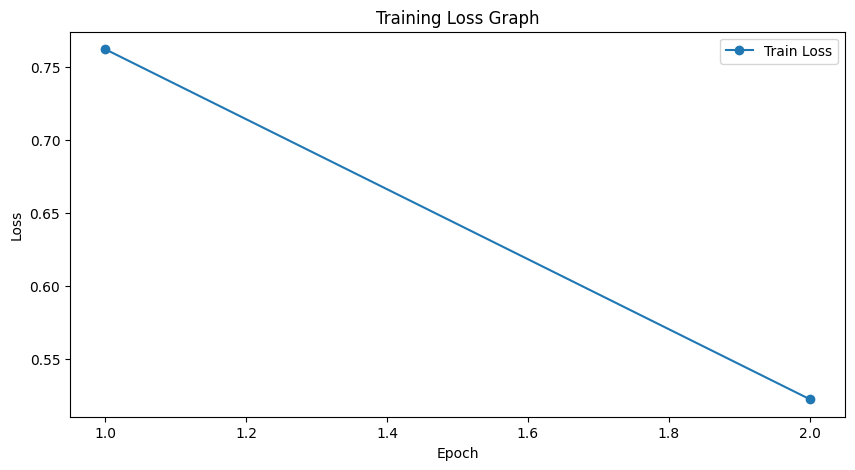

In [26]:
train_losses = []

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    count = 0

    for batch_idx, (images, path_lengths, nodes_astar, nodes_bfs) in enumerate(tqdm(dataloader, desc=f"Training epoch [{epoch+1}/{EPOCHS}]")):

        images = images.to(device)
        path_lengths = path_lengths.float().to(device)
        nodes_astar = nodes_astar.float().to(device)

        # Step 1: Encode images to latents using VAE
        with torch.no_grad():
            z = vae.encode(images).latent_dist.sample()  # shape: (B, 4, 64, 64)

        # Step 2: Sample timesteps & add noise
        timesteps = torch.randint(0, NUM_TIMESTEPS, (z.size(0),), device=device).long()
        noise = torch.randn_like(z)
        noisy_z = scheduler.add_noise(z, noise, timesteps)

        # Step 3: Prepare conditional and unconditional embeddings
        cond_input = torch.stack([path_lengths, nodes_astar], dim=-1)  
        cond_embed = custom_diffusion_model.condition_multidimensional_embedding(cond_input)                

        zero_input = torch.zeros_like(cond_input)
        uncond_embed = custom_diffusion_model.condition_multidimensional_embedding(zero_input)

        context = torch.cat([uncond_embed, cond_embed], dim=0)       

        # Step 4: Forward pass with classifier-free guidance
        noisy_z = noisy_z.repeat(2, 1, 1, 1)                          
        timesteps = timesteps.repeat_interleave(2)                   

        noise_pred = unet(noisy_z, timesteps, encoder_hidden_states=context).sample
        noise_uncond, noise_cond = noise_pred.chunk(2)

        guided_noise = noise_uncond + GUIDANCE_SCALE * (noise_cond - noise_uncond)

        # Step 5: Loss and optimization
        loss = F.smooth_l1_loss(guided_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)
        count += images.size(0)

    avg_loss = epoch_loss / count
    train_losses.append(avg_loss)
    print(f"[Epoch {epoch+1}] Loss: {avg_loss:.6f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Graph')
plt.legend()
file_name = f"loss_curve_diffusion_multi_feat_{formatted_time}"
plt.savefig(os.path.join(loss_curves_folder, file_name))
plt.show()


In [27]:
if not os.path.exists(f"../data/loss_curves_{formatted_time}/stable_diffusion_diffusion_models/"):
    os.makedirs(f"../data/loss_curves_{formatted_time}/stable_diffusion_diffusion_models/")
torch.save({
    'diffusion_state_dict': unet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses
}, f'../data/loss_curves_{formatted_time}/stable_diffusion_diffusion_models/diffusion_weights_multi_feat.pth')
print("Diffusion weights saved to diffusion_weights_multi_feat.pth")

Diffusion weights saved to diffusion_weights_multi_feat.pth


### Stable Diffusion Testing

In [45]:
def generate_maze_from_test(sample_idx=None, num_steps=50):
    unet.eval()
    scheduler.set_timesteps(num_steps)
    
    if sample_idx is None:
        sample_idx = random.randint(0, len(test_dataset) - 1)
    
    test_img, test_path_length, nodes_astar, nodes_bfs = test_dataset[sample_idx]
    path_tensor = torch.tensor([test_path_length]).float().to(device)
    nodes_astar_tensor = torch.tensor([nodes_astar]).float().to(device)
    combined_features = torch.stack((path_tensor, nodes_astar_tensor), dim=-1)
    # context = diffusion_model.condition_multidimensional_embedding(
    #     torch.tensor([test_path_length], device=device).float()
    # )

    context = custom_diffusion_model.condition_multidimensional_embedding(combined_features)
    
    latent = torch.randn((1, 4, 8, 8), device=device)
    
    for t in scheduler.timesteps:
        timestep = torch.tensor([t], device=device)
        with torch.no_grad():
            pred = unet(latent, timestep, encoder_hidden_states=context).sample
        latent = scheduler.step(pred, t, latent).prev_sample
    
    with torch.no_grad():
        generated_image = vae.decode(latent/0.18215).sample
        # generated_image = decoder(latent / 0.18215)
    
    return generated_image, test_img, test_path_length

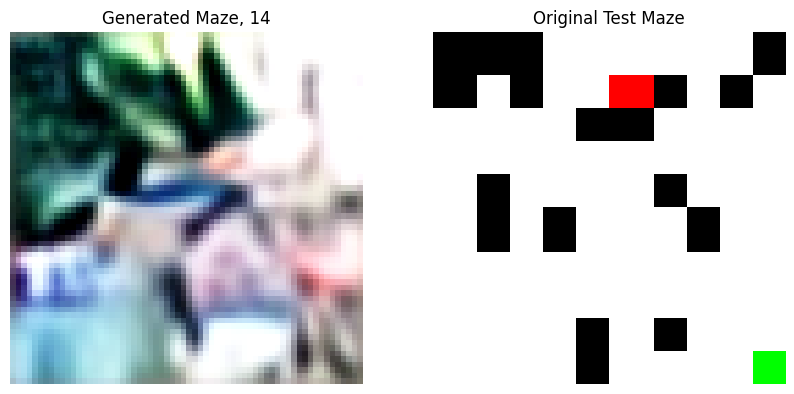

In [46]:
generated, original, test_path_length = generate_maze_from_test(num_steps=100)
image = generated[0].detach().cpu()

# Convert from [-1, 1] to [0, 1]
image = (image + 1.0) / 2.0
generated = torch.clamp(image, 0.0, 1.0)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(generated.squeeze(0).permute(1, 2, 0).cpu().numpy(), cmap='gray')
# plt.imshow(generated.squeeze(0).cpu().numpy(), cmap='gray')
plt.title(f"Generated Maze, {test_path_length}")
plt.axis("off")

plt.subplot(1, 2, 2)
# plt.imshow(original.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.imshow(original.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title("Original Test Maze")
plt.axis("off")
file_name = f"diffusion_image_generation_multi_feat_{formatted_time}"
plt.savefig(os.path.join(loss_curves_folder, file_name))
plt.show()